C:\Users\USER\AppData\Local\Temp\ipykernel_5208\412180074.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Number of classes: 5
Found 297 files belonging to 5 classes.
Epoch 1/15
7/7 [==============================] - 8s 1s/step - loss: 2.1309 - accuracy: 0.2054 - val_loss: 1.5924 - val_accuracy: 0.2188
Epoch 2/15
7/7 [==============================] - 6s 830ms/step - loss: 1.5927 - accuracy: 0.2723 - val_loss: 1.5573 - val_accuracy: 0.3125
Epoch 3/15
7/7 [==============================] - 6s 813ms/step - loss: 1.5762 - accuracy: 0.3170 - val_loss: 1.5578 - val_accuracy: 0.2812
Epoch 4/15
7/7 [==============================] - 5s 727ms/step - loss: 1.5521 - accuracy: 0.3393 - val_loss: 1.4891 - val_accuracy: 0.4531
Epoch 5/15
7/7 [==============================] - 5s 708ms/step - loss: 1.5046 - accuracy: 0.3571 - val_loss: 1.4200 - val_accuracy: 0.4844
Epoch 6/15
7/7 [==============================] - 5s 702ms/step - loss: 1.4428 - accuracy: 0.4375 - val_loss: 1.3811 - val_accuracy: 0.4688
Epoch 7/15
7/7 [==============================] - 5s 707ms/step - loss: 1.3389 - accuracy: 0.5089 - va

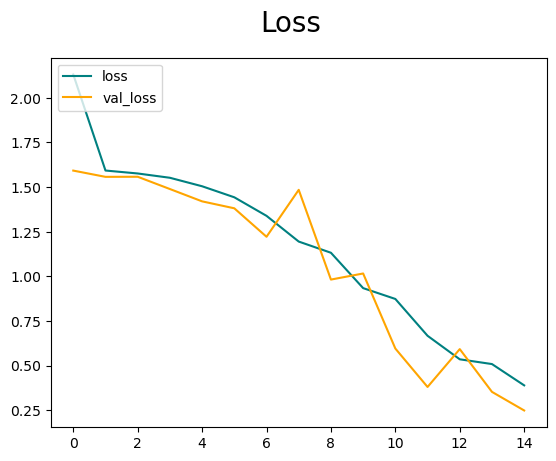

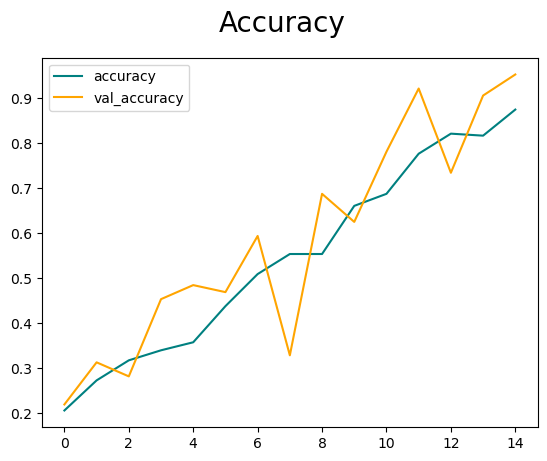

1/1 [==============================] - 0s 412ms/step - loss: 0.1171 - accuracy: 1.0000
Test loss: 0.11712172627449036
Test accuracy: 1.0
1/1 [==============================] - 0s 164ms/step
Precision: 1.0, Recall: 1.0, Accuracy: 1.0


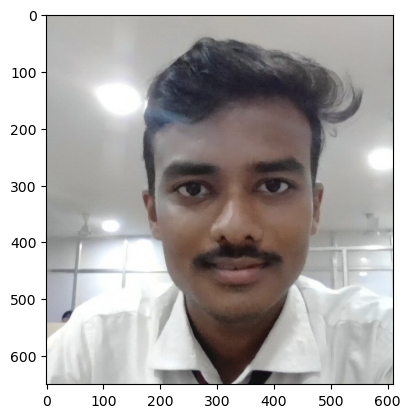

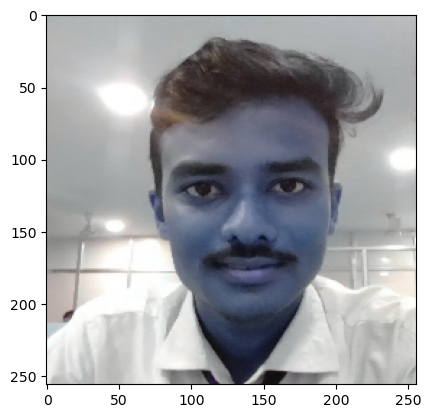

1/1 [==============================] - 0s 69ms/step
[[0. 0. 1. 0. 0.]]
The predicted emotion is: Happy


In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Avoid OOM error by setting GPU Memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

data_dir = 'data3'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Remove corrupted images
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# Count the number of classes
num_classes = len(os.listdir(data_dir))
print(f'Number of classes: {num_classes}')

# Load data
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode="categorical",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

# Normalize data
data = data.map(lambda x, y: (x / 255.0, y))

# Determine dataset size
dataset_size = len(data)

# Split data into training, validation, and test sets
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = int(0.1 * dataset_size)

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

# Build the model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer for num_classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
hist = model.fit(train_data, validation_data=val_data, epochs= 15, callbacks=[early_stopping])

# Plot loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Plot accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate the model
results = model.evaluate(test_data)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

# Calculate precision, recall, and accuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for images, labels in test_data:
    predictions = model.predict(images)
    pre.update_state(labels, predictions)
    re.update_state(labels, predictions)
    acc.update_state(labels, predictions)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

# Test the model with a new image
img = cv2.imread('happy1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

predictions = model.predict(np.expand_dims(resize, axis=0))

# Get the class label
class_labels = ['Angry', 'Neutral', 'Happy', 'Sad', 'Disgust']
print(predictions)
predicted_class_index = np.argmax(predictions)

#prediction of images
if predicted_class_index < len(class_labels):
    predicted_class = class_labels[predicted_class_index]
    print(f'The predicted emotion is: {predicted_class}')
else: 
    print("Error: Predicted class index exceeds class labels list.")


### Segregation of eyes, mouth and face using Haarcascade classifier

Face 1: x=138, y=199, width=295, height=295


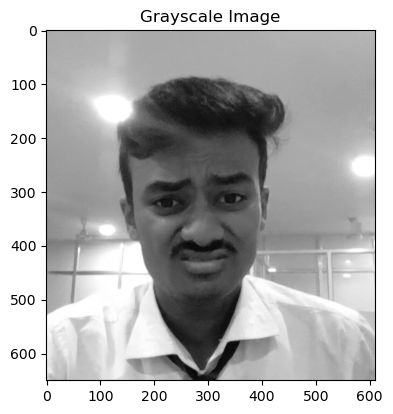

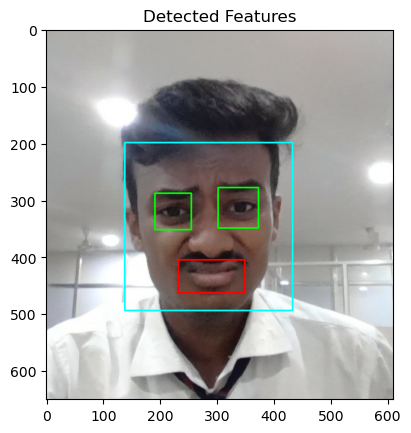

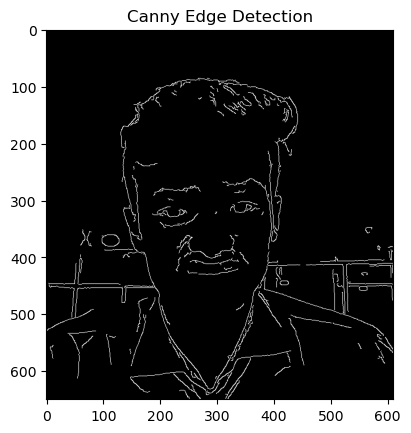

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the Haar cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_smile.xml")

# Check if the cascade files are loaded successfully
if face_cascade.empty() or eye_cascade.empty() or smile_cascade.empty():
    print("Error loading Haar cascades.")

# Read the image
img = cv2.imread("disgust1.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect edges using Canny
edges = cv2.Canny(gray, 70, 130)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

# Loop over the detected faces
for i, (x, y, w, h) in enumerate(faces):
    # Draw a rectangle around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 0), 2)
    print(f"Face {i + 1}: x={x}, y={y}, width={w}, height={h}")
    
    # Region of interest for eyes and smile detection
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = img[y:y + h, x:x + w]
    
    # Detect eyes in the region of interest
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for i, (ex, ey, ew, eh) in enumerate(eyes):
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
        # print(f"Eyes {i + 1}: x={ex}, y={ey}, width={ew}, height={eh}")
    
    # Detect smiles in the region of interest
    smiles = smile_cascade.detectMultiScale(roi_gray, scaleFactor=1.8, minNeighbors=20)
    for (sx, sy, sw, sh) in smiles:
        cv2.rectangle(roi_color, (sx, sy), (sx + sw, sy + sh), (0, 0, 255), 2)



# # Create a mask using edges
# mask = np.zeros_like(img)
# mask[edges != 0] = [255, 255, 255]
# Display the original image with rectangles


#grayscale
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.show()
# plt.axis('off')


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Detected Features')
plt.show()

# Display the edge-detected image
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.show()


# Segregation of eyes using Haarcascade classifier

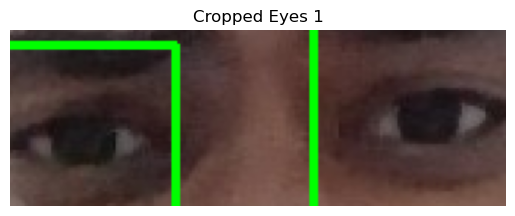

In [23]:
cropped_eyes = []

# Loop over the detected faces
for (x, y, w, h) in faces:
    # Define region of interest (ROI) for eyes within the face
    roi_gray = gray[y:y + h // 2, x:x + w]  # Only consider the top half of the face for eyes
    roi_color = img[y:y + h // 2, x:x + w]

    # Detect eyes within the face ROI
    eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=10)
    
    # Sort detected eyes by x coordinate to ensure they are left to right
    eyes = sorted(eyes, key=lambda eye: eye[0])

    # Check if two eyes are detected
    if len(eyes) >= 2:
        ex1, ey1, ew1, eh1 = eyes[0]
        ex2, ey2, ew2, eh2 = eyes[1]

        # Get the combined bounding box for both eyes
        x1, y1 = min(ex1, ex2), min(ey1, ey2)
        x2, y2 = max(ex1 + ew1, ex2 + ew2), max(ey1 + eh1, ey2 + eh2)
        
        # Crop the region containing both eyes
        cropped_eyes_img = roi_color[y1:y2, x1:x2]
        cropped_eyes.append(cropped_eyes_img)

        # Draw rectangles around the detected eyes
        # cv2.rectangle(roi_color, (ex1, ey1), (ex1 + ew1, ey1 + eh1), (0, 255, 0), 2)
        # cv2.rectangle(roi_color, (ex2, ey2), (ex2 + ew2, ey2 + eh2), (0, 255, 0), 2)

    # Draw a rectangle around the face
    # cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 0), 2)

# Display each cropped region containing both eyes
for i, eyes_img in enumerate(cropped_eyes):
    plt.figure()
    plt.imshow(cv2.cvtColor(eyes_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Cropped Eyes {i+1}')
    plt.axis('off')
    plt.show()

### Segregation of mouth using Haarcascade classifier

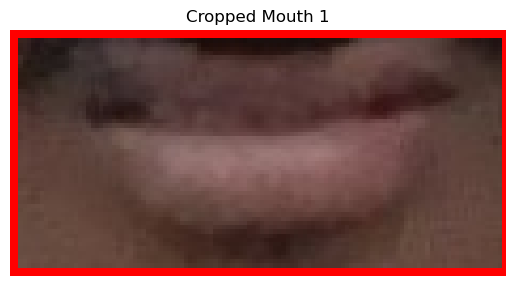

In [24]:
cropped_mouths = []

# Loop over the detected faces
for (x, y, w, h) in faces:
    # Define region of interest (ROI) for mouth within the lower half of the face
    roi_gray = gray[y + h // 2:y + h, x:x + w]
    roi_color = img[y + h // 2:y + h, x:x + w]

    # Detect smiles (mouth) within the ROI
    mouths = smile_cascade.detectMultiScale(roi_gray, scaleFactor=1.8, minNeighbors=20)

    for (sx, sy, sw, sh) in mouths:
        # Crop each detected mouth
        cropped_mouth = roi_color[sy:sy+sh, sx:sx+sw]
        cropped_mouths.append(cropped_mouth)

        # Draw rectangle around each mouth
        cv2.rectangle(roi_color, (sx, sy), (sx + sw, sy + sh), (0, 0, 255), 2)

# Display the detected mouths with bounding boxes
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.title('Detected Mouths')
# plt.axis('off')
# plt.show()

# Display each cropped mouth image
for i, mouth in enumerate(cropped_mouths):
    plt.figure()
    plt.imshow(cv2.cvtColor(mouth, cv2.COLOR_BGR2RGB))
    plt.title(f'Cropped Mouth {i+1}')
    plt.axis('off')
    plt.show()

### Histogram of cropped eye region

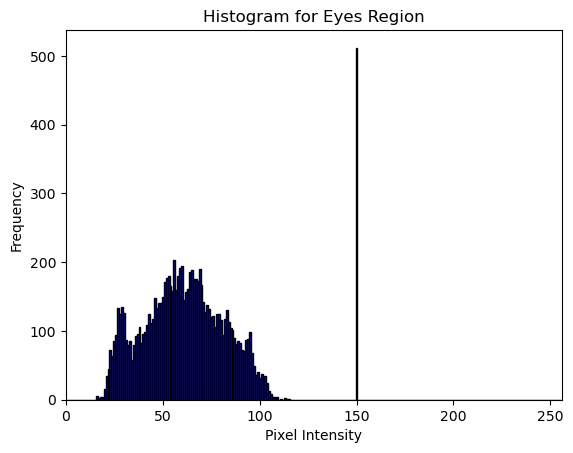

In [25]:
import matplotlib.pyplot as plt

# Assume `cropped_eyes_img` is the image of the cropped eyes region
gray_eyes = cv2.cvtColor(cropped_eyes_img, cv2.COLOR_BGR2GRAY)

# Calculate histogram for eyes region
hist_eyes = cv2.calcHist([gray_eyes], [0], None, [256], [0, 256])

# Plot histogram for eyes region as bars
plt.figure()
plt.bar(range(256), hist_eyes.flatten(), color='blue', width=1.0, align='center', edgecolor='black')
plt.title('Histogram for Eyes Region')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.xlim([0, 256])
# plt.grid(axis='y', alpha=0.75)
plt.show()

### histogram of cropped mouth region

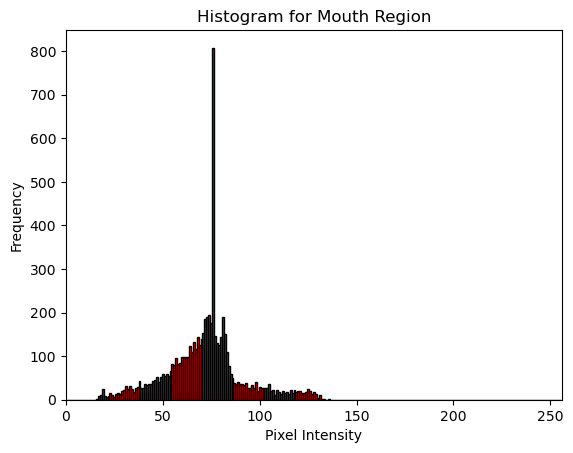

In [26]:
# Assume `cropped_mouth_img` is the image of the cropped mouth region
gray_mouth = cv2.cvtColor(cropped_mouth, cv2.COLOR_BGR2GRAY)

# Calculate histogram for mouth region
hist_mouth = cv2.calcHist([gray_mouth], [0], None, [256], [0, 256])

# Plot histogram for mouth region as bars
plt.figure()
plt.bar(range(256), hist_mouth.flatten(), color='red', width=1.0, edgecolor='black')
plt.title('Histogram for Mouth Region')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.xlim([0, 256])
plt.show()

### Confusion matrix

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define your class labels
class_labels = ['Angry', 'Neutral', 'Happy', 'Sad','disgust',]

# Extract the true label and predicted label
y_true = []  # Replace 'true_label' with the true label value
y_pred = []  # Replace 'predicted_label' with the predicted label value
for x, y in test_data:
    
    yhat = model.predict(x)
    y_true.extend(np.argmax(yhat, axis=1,))  # Use 'y' instead of 'yhat' for true values
    y_pred.extend(np.argmax(yhat, axis=1))

# # Calculate and print metrics
# print("Accuracy Score:", accuracy_score(y_true, y_pred))
# print("Precision Score (weighted):", precision_score(y_true, y_pred, average='weighted'))
# print("Recall Score (weighted):", recall_score(y_true, y_pred, average='weighted'))
# print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred, labels=np.arange(len(class_labels)), target_names=class_labels))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred, labels=np.arange(len(class_labels))))







1/1 [==============================] - 0s 47ms/step
Classification Report:
               precision    recall  f1-score   support

       Angry       1.00      1.00      1.00         1
     Neutral       1.00      1.00      1.00         2
       Happy       1.00      1.00      1.00         2
         Sad       1.00      1.00      1.00         2
     disgust       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion Matrix:
 [[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 2 0]
 [0 0 0 0 2]]


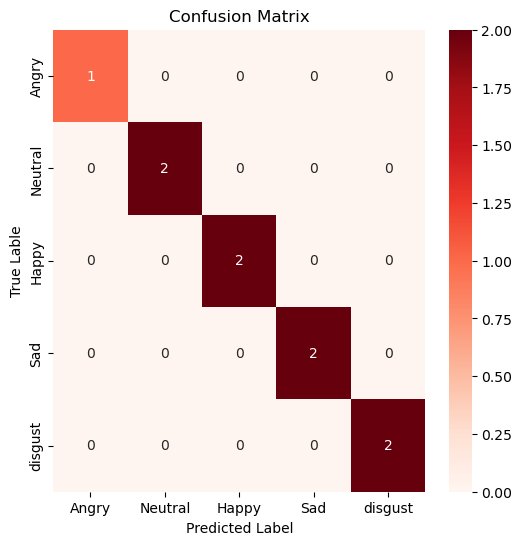

In [34]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(len(class_labels))))

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Lable')
plt.show()